In [1]:
from tqdm import tqdm_notebook as tqdm

# Cross Validation

In [ ]:
import os
import sys
sys.path.append('../models/topic_model/')
import sampler_cy
import json

## data
data_input = []
with open('../models/topic_model/labeled_data/doc_vecs.json') as data:
    for line in data:
        data_input.append(json.loads(line))
vocab = open('../models/topic_model/labeled_data/vocab.txt').read().split('\n')[:-1]

from sklearn.model_selection import KFold
import numpy as np 
kf = KFold(n_splits=5)

labeled_data_idx = list(filter(lambda x: x[1]['has_labels'], list(enumerate(data_input))))
labeled_data_idx = np.array(list(map(lambda x: x[0], labeled_data_idx)))

num_iterations = 1000
kfold = 0

for train_idx, test_idx in kf.split(labeled_data_idx):
    outdir = os.path.join('crossfold-topic-model', 'fold-%d' % kfold)
    os.makedirs(outdir, exist_ok=True)
    ## 
    test_examples = labeled_data_idx[test_idx]
    for idx in test_examples:
        data_input[idx]['has_labels'] = False

    ## sampler
    sampler = sampler_cy.BOW_Paragraph_GibbsSampler(data_input, vocab=vocab)
    sampler.initialize()
    for i in tqdm(range(num_iterations)):
        sampler.sample_pass()
    sampler.save_state(outdir)
    np.savetxt(os.path.join(outdir, 'test-examples.txt'), test_examples)    
    
    kfold += 1
    del sampler

# Read in Cross-Validated Data

In [8]:
import os
import glob
import json
import pandas as pd 
import ast
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
input_data = []
with open('../models/topic_model/labeled_data/doc_vecs.json') as f:
    for line in f:
        input_data.append(json.loads(line))

In [77]:
micro_micro_results = []
macro_results = []
for fold in glob.glob('../models/topic_model/crossfold-topic-model/*'):
    pardoc_to_type_file = os.path.join(fold, 'pardoc_to_type.txt')
    pardoc_to_type = json.load(open(pardoc_to_type_file))

    test = open(os.path.join(fold, 'test-examples.txt'))
    test_set = list(map(lambda x: int(ast.literal_eval(x.strip())), test.readlines()))

    y_pred, y_true = [], []
    for e in test_set:
        micro_micro_results.append({
            'f1_score': f1_score(input_data[e]['labels'], pardoc_to_type[e], average='micro'),
            'length': len(pardoc_to_type[e])
        })
        y_pred += pardoc_to_type[e]
        y_true += input_data[e]['labels']
    
    macro_results.append({
        'macro': f1_score(y_true, y_pred, average='macro'),
        'micro': f1_score(y_true, y_pred, average='micro')
    })

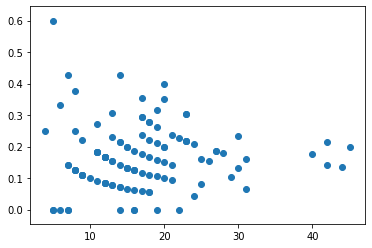

In [79]:
results_df = pd.DataFrame(results)
plt.scatter(results_df['length'], results_df['f1_score'])

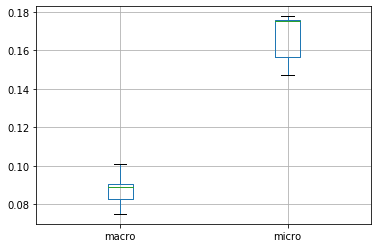

In [81]:
pd.DataFrame(macro_results).boxplot()

# Read in Data

In [12]:
import numpy as np 
import os
import json
import pandas as pd 

In [24]:
label_mapper_inverse = {
    0: 'LEAD',
    1: 'CIRC',
    2: 'MAIN',
    3: 'VERB',
    4: 'CONS',
    5: 'PREV',
    6: 'EVAL',
    7: 'HIST',
    8: 'EXPE',
    9: 'SECD',
    10: 'EXPL',
    -1: np.nan
}

In [13]:
os.listdir('../models/topic_model/labeled_output/model-state-iter-9999.pkl/')

['doc_by_wordtopic.txt',
 'pardoc_to_type.txt',
 'partype_by_wordtopic.txt',
 'switching_variable_counts.txt',
 'vocab_by_wordtopic.txt']

In [14]:
pardoc_to_type = json.load(open('../models/topic_model/labeled_output/model-state-iter-999.pkl/pardoc_to_type.txt'))

In [16]:
pardoc_to_type_df = pd.DataFrame(pardoc_to_type)

In [30]:
(pardoc_to_type_df.unstack().dropna()
 .value_counts()
 .reset_index()
 .assign(index=lambda df: df['index'].map(label_mapper_inverse))
 .set_index('index')[0]
)

index
VERB    22693
CIRC    11951
MAIN     8508
PREV     6549
EVAL     5784
CONS     5672
HIST     4020
LEAD     3426
EXPE     2493
SECD     1308
EXPL      224
NaN         3
Name: 0, dtype: int64